# Lab 6 Text Mining

Text Preprocessing steps
0. Noise removal
1. Sentence splitter and tokenization 
2. Stemming and lemmatization 
3. Stopwards Removal - todo
4. POS tagging
5. Chunking 
6. N-grams  
After Doing Text Preprocessing do Text Clustering  by using K- mean

http://qwone.com/~jason/20Newsgroups/  
Download 20news-19997.tar.gz datasets from this link

Calculate homogeneity score and V score  
  
For pre-processing, pick 1 file from 3 categories (assuming each has 3 paragraphs)  
For clustering, pick 10 files from 5 categories

In [1]:
from sklearn.datasets import fetch_20newsgroups
from io import StringIO
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk, RegexpParser, ngrams
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import os
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from IPython.display import display
from nltk.chunk.regexp import ChunkString, ChunkRule, ChinkRule
from nltk.tree import Tree
from nltk.chunk import RegexpChunkParser
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
class NewsGroupFile():
    def __init__(self, f):
        self.f = f
    def removeHeader(self):
        while not 'Lines' in self.f.readline():
            pass
    def get_string(self):
        return self.f.read()
    
    @staticmethod
    def stringRemoveHeader(string):
        stream = StringIO(string)
        while not 'Lines' in stream.readline():
            pass
        return stream.read()
    
    @staticmethod
    def string_noise_cancel(string):
        string = NewsGroupFile.stringRemoveHeader(string)
        string = re.sub(r'(\w)-(\w)', r'\g<1>\g<2>', string)
        string = re.sub('[^A-Za-z]', ' ', string)
        string = re.sub('\n|\t', ' ', string)
        string = re.sub('\ +', ' ', string)
        return string

class TextProcessor():
    def __init__(self):
        pass
    
    stop_words = set(stopwords.words('english'))
    
    @staticmethod
    def sent_tokenize(sent):
        sents = sent_tokenize(sent)
        sents_cleaned = list()
        for i in sents:
            for j in i.splitlines():
                s = j.strip()
                if s != '':
                    sents_cleaned.append(s)
        return sents_cleaned
    
    @staticmethod
    def get_wordnet_pos_from_pos_tag(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    @staticmethod
    def word_tokenize(sent):
        words = word_tokenize(sent)
        words_cleaned = list()
        for i in words:
            w = i.strip()
            words_cleaned.append(w.lower())
        return words_cleaned
       
    @staticmethod
    def remove_stop_words(string):
        words = TextProcessor.word_tokenize(string)
        removed = []
        for i in words:
            if i not in TextProcessor.stop_words:
                removed.append(i)
        return TextProcessor.words_to_string(removed)
    
    @staticmethod
    def chunk(words_tagged):
        tree = Tree('S', [x for x in words_tagged])
        reg = r"""
            NN: {<JJ.*><NN.*>+|<NN.*><NN.*>+}
            VB: {<RB.*><VB.*>}
            """
        parser = RegexpParser(reg)
        return parser.parse(tree)
        tree = Tree('S', [('the', 'DT'), ('book', 'NN'), 
               ('has', 'VBZ'), ('many', 'JJ'), ('chapters', 'NNS')]) 
        chunk_rule = ChunkRule('<DT><NN.*><.*>*<NN.*>', 'chunk determiners and nouns')   
        chink_rule = ChinkRule('<VB.*>', 'chink verbs')
        chunker = RegexpChunkParser([chunk_rule, chink_rule], chunk_label ='CP')
        chunk_tree = chunker.parse(words_tagged)
        return chunk_tree
    
    @staticmethod
    def words_to_string(words):
        text = ' '.join(words)
        return text
    
    @staticmethod
    def pos_tag(words):
        return pos_tag(words)
    
    @staticmethod
    def stem_lemmatize_tagged(words_tagged):
        porter = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        words = [x for x in words_tagged]
        for i in range(len(words)):
            pos = TextProcessor.get_wordnet_pos_from_pos_tag(words[i][1])
            if pos:
                words[i] = (lemmatizer.lemmatize(\
                                            porter.stem(words[i][0]), \
                                            pos=pos), words[i][1])
            else:
                words[i] = (lemmatizer.lemmatize(\
                                            porter.stem(words[i][0])), words[i][1])
        return words
    
    @staticmethod
    def get_ngram(tokens, n):
        return ngrams(tokens, n)
    
    @staticmethod
    def remove_stop_words_tagged(words):
        removed = []
        for i in words:
            if len(i[0]) > 2 and i[0] not in TextProcessor.stop_words:
                removed.append(i)
        return removed
    
    @staticmethod
    def stem_lemmatize(text):
        words = TextProcessor.word_tokenize(text)
        words = TextProcessor.stem_lemmatize_words(words)
        return TextProcessor.words_to_string(words)
    
    @staticmethod
    def sent_stem_lemmatize_chunk_word_tokenize(sent):
        porter = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        words = TextProcessor.word_tokenize(sent)
        words_tagged = pos_tag(words)
        
        # Stemming
        for i in range(len(words)):
            words[i] = porter.stem(words_tagged[i][0])
        
        # Lemmatization
        for i in range(len(words)):
            pos = TextProcessor.get_wordnet_pos_from_pos_tag(words_tagged[i][1])
            if pos:
                words[i] = lemmatizer.lemmatize(\
                                            words_tagged[i][0], \
                                            pos=pos)
            else:
                words[i] = lemmatizer.lemmatize(\
                                            words_tagged[i][0])
        words_tagged = [(words[i], words_tagged[i][1]) for i in range(len(words))]
        words_chunked = TextProcessor.chunk(words_tagged)
        words = [i[0] for i in words_chunked]
        return words

# Text Preprocessing

In [3]:
def load_data_preprocessing():
    categories = [
        'alt.atheism',
        'comp.graphics',
        'sci.space'
    ]
    if "20_newsgroups" not in os.listdir():
        print("Cannot find data files, exiting.")
        print("Please copy 20_newsgroups folder into the current directory before retrying execution")
    data_path = "20_newsgroups/"
    data = []
    for cat in categories:
        files = [data_path + cat + "/" + x for x in os.listdir(data_path + cat)]
        for i in files:
            ok = False
            with open(i, mode='r', encoding='utf-8', errors='ignore') as file:
                text = file.read()
                if text.count('\n\n') > 5:
                    data.append([text, cat])
                    ok = True
            if ok:
                break
                    
    return data

In [4]:
data_pp = load_data_preprocessing()

## Noise Cancelling

In [5]:
news_cleaned = []
for i in range(len(data_pp)):
    news_cleaned.append(NewsGroupFile.string_noise_cancel(data_pp[i][0]))
print(news_cleaned[1])

Distribution world MessageID rs jk dna menudo uh edu NNTPPostingHost menudo uh edu I am happy to announce the first public release of the bit program an INTERACTIVE FULL COLOR image viewer and editor based on SGI GL Besides typical touchup tasks such as crop rotate smooth etc bit offers some unique features not available in similar programs such as text and vector support and the separation of text and image The following is the relevant sections from the man page PreRelease of May BIT L NAME bit Bitmap Image Touchup for SGI Workstations DESCRIPTION bit is an interactive full color image viewer and editor based on Silicon Graphics GL As a full color program bit handles images of both bits and color index in a natural and efficient manner As an image viewer bit allows list of images to be displayed in their original type bits or color index in any order and in any of the many builtin styles of display You can walk up and down the list using mouse and keyboard or you can let bit do the w

## Tokenization

In [6]:
news_tokenized = []
for i in range(len(news_cleaned)):
    news_tokenized.append(TextProcessor.word_tokenize(news_cleaned[i]))
for i in news_tokenized[1]:
    print(i)

distribution
world
messageid
rs
jk
dna
menudo
uh
edu
nntppostinghost
menudo
uh
edu
i
am
happy
to
announce
the
first
public
release
of
the
bit
program
an
interactive
full
color
image
viewer
and
editor
based
on
sgi
gl
besides
typical
touchup
tasks
such
as
crop
rotate
smooth
etc
bit
offers
some
unique
features
not
available
in
similar
programs
such
as
text
and
vector
support
and
the
separation
of
text
and
image
the
following
is
the
relevant
sections
from
the
man
page
prerelease
of
may
bit
l
name
bit
bitmap
image
touchup
for
sgi
workstations
description
bit
is
an
interactive
full
color
image
viewer
and
editor
based
on
silicon
graphics
gl
as
a
full
color
program
bit
handles
images
of
both
bits
and
color
index
in
a
natural
and
efficient
manner
as
an
image
viewer
bit
allows
list
of
images
to
be
displayed
in
their
original
type
bits
or
color
index
in
any
order
and
in
any
of
the
many
builtin
styles
of
display
you
can
walk
up
and
down
the
list
using
mouse
and
keyboard
or
you
can
let
bit
do
the
w

## POS Tagging

In [7]:
news_tagged = []
for i in range(len(news_tokenized)):
    news_tagged.append(TextProcessor.pos_tag(news_tokenized[i]))
for i in news_tagged[1]:
    print(i[1], "\t", i[0])    

NN 	 distribution
NN 	 world
NN 	 messageid
NN 	 rs
NN 	 jk
NN 	 dna
NN 	 menudo
JJ 	 uh
NN 	 edu
NN 	 nntppostinghost
NN 	 menudo
IN 	 uh
NN 	 edu
NN 	 i
VBP 	 am
JJ 	 happy
TO 	 to
VB 	 announce
DT 	 the
JJ 	 first
JJ 	 public
NN 	 release
IN 	 of
DT 	 the
NN 	 bit
NN 	 program
DT 	 an
JJ 	 interactive
JJ 	 full
NN 	 color
NN 	 image
NN 	 viewer
CC 	 and
NN 	 editor
VBN 	 based
IN 	 on
JJ 	 sgi
NN 	 gl
IN 	 besides
JJ 	 typical
NN 	 touchup
NNS 	 tasks
JJ 	 such
IN 	 as
NN 	 crop
VBP 	 rotate
JJ 	 smooth
FW 	 etc
NN 	 bit
VBZ 	 offers
DT 	 some
NN 	 unique
VBZ 	 features
RB 	 not
JJ 	 available
IN 	 in
JJ 	 similar
NNS 	 programs
JJ 	 such
IN 	 as
NN 	 text
CC 	 and
NN 	 vector
NN 	 support
CC 	 and
DT 	 the
NN 	 separation
IN 	 of
NN 	 text
CC 	 and
NN 	 image
DT 	 the
NN 	 following
VBZ 	 is
DT 	 the
JJ 	 relevant
NNS 	 sections
IN 	 from
DT 	 the
NN 	 man
NN 	 page
NN 	 prerelease
IN 	 of
MD 	 may
VB 	 bit
JJ 	 l
NN 	 name
NN 	 bit
JJ 	 bitmap
NN 	 image
NN 	 touchup
IN 	 for
JJ 	

MD 	 will
VB 	 satisfy
JJS 	 most
IN 	 of
PRP$ 	 your
VBG 	 editing
NNS 	 needs
IN 	 in
NN 	 addition
DT 	 the
JJ 	 external
NN 	 filter
CC 	 and
JJ 	 dynamical
NN 	 kernel
MD 	 will
VB 	 utilize
DT 	 any
NN 	 program
PRP 	 you
RB 	 already
VBP 	 have
RB 	 so
VB 	 try
PRP 	 it
CC 	 and
PRP 	 you
MD 	 will
VB 	 like
PRP 	 it
IN 	 as
RB 	 always
DT 	 any
NNS 	 comments
NN 	 bug
NNS 	 reports
VBP 	 are
JJ 	 welcome


## Stemming, Lemmatization

In [8]:
news_stemmed_and_lemmatized = []
for i in range(len(news_tagged)):
    news_stemmed_and_lemmatized.append(TextProcessor.stem_lemmatize_tagged(news_tagged[i]))
for i in news_stemmed_and_lemmatized[1]:
    print(i[0])

distribut
world
messageid
r
jk
dna
menudo
uh
edu
nntppostinghost
menudo
uh
edu
i
be
happi
to
announc
the
first
public
releas
of
the
bit
program
an
interact
full
color
imag
viewer
and
editor
base
on
sgi
gl
besid
typic
touchup
task
such
a
crop
rotat
smooth
etc
bit
offer
some
uniqu
featur
not
avail
in
similar
program
such
a
text
and
vector
support
and
the
separ
of
text
and
imag
the
follow
be
the
relev
section
from
the
man
page
prereleas
of
may
bite
l
name
bit
bitmap
imag
touchup
for
sgi
workstat
descript
bit
be
an
interact
full
color
imag
viewer
and
editor
base
on
silicon
graphic
gl
a
a
full
color
program
bit
handl
imag
of
both
bit
and
color
index
in
a
natur
and
effici
manner
a
an
imag
viewer
bit
allow
list
of
imag
to
be
display
in
their
origin
type
bit
or
color
index
in
ani
order
and
in
ani
of
the
mani
builtin
style
of
display
you
can
walk
up
and
down
the
list
use
mous
and
keyboard
or
you
can
let
bite
do
the
walk
for
you
the
slideshow
with
the
pan
and
zoom
featur
larg
imag
can
be
view
in

## Stop words removal

In [9]:
news_no_stop_words = []
for i in range(len(news_stemmed_and_lemmatized)):
    news_no_stop_words.append(TextProcessor.remove_stop_words_tagged(news_stemmed_and_lemmatized[i]))
for i in news_no_stop_words[1]:
    print(i[0])

distribut
world
messageid
dna
menudo
edu
nntppostinghost
menudo
edu
happi
announc
first
public
releas
bit
program
interact
full
color
imag
viewer
editor
base
sgi
besid
typic
touchup
task
crop
rotat
smooth
etc
bit
offer
uniqu
featur
avail
similar
program
text
vector
support
separ
text
imag
follow
relev
section
man
page
prereleas
may
bite
name
bit
bitmap
imag
touchup
sgi
workstat
descript
bit
interact
full
color
imag
viewer
editor
base
silicon
graphic
full
color
program
bit
handl
imag
bit
color
index
natur
effici
manner
imag
viewer
bit
allow
list
imag
display
origin
type
bit
color
index
ani
order
ani
mani
builtin
style
display
walk
list
use
mous
keyboard
let
bite
walk
slideshow
pan
zoom
featur
larg
imag
view
full
without
limit
window
screen
size
imag
editor
bit
perform
larg
number
imag
edit
process
task
accur
effici
keep
inform
loss
ani
stage
edit
process
absolut
minimum
perform
subpixel
sampl
automat
conserv
input
imag
type
whenev
possibl
avoid
unnecessari
promot
quantiz
input
imag
also

## Chunking

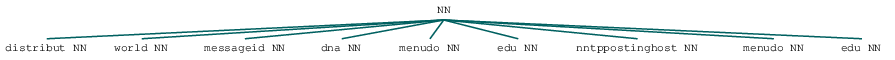

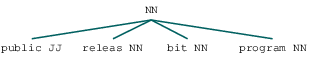

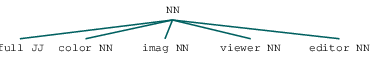

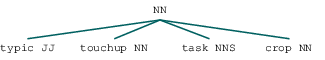

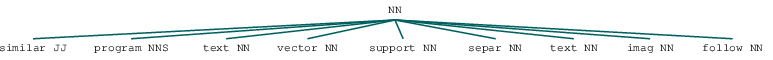

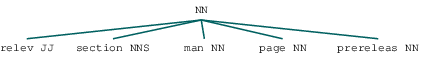

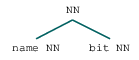

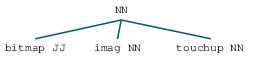

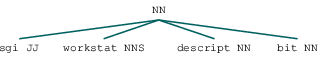

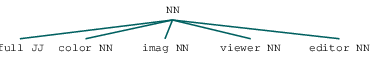

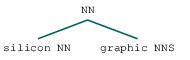

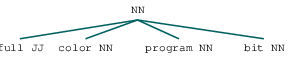

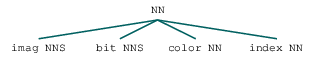

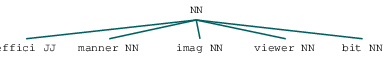

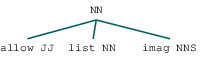

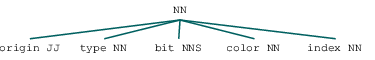

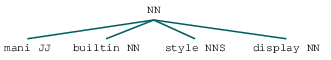

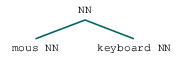

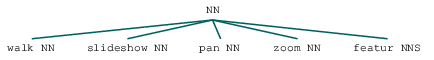

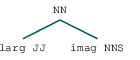

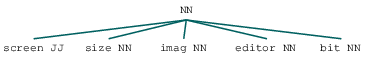

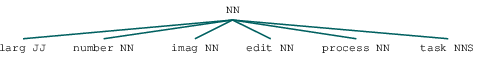

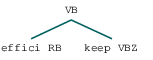

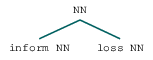

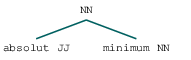

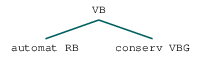

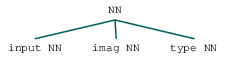

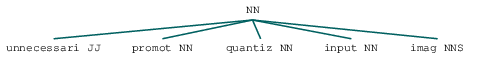

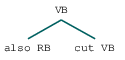

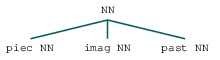

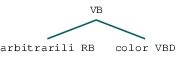

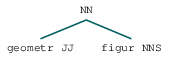

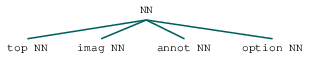

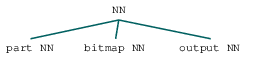

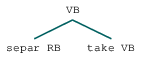

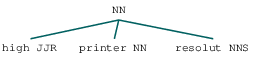

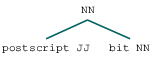

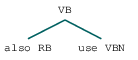

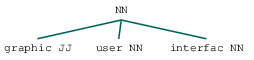

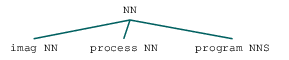

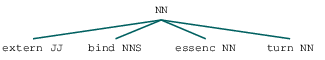

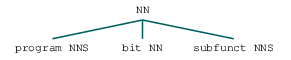

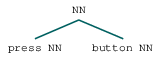

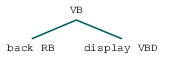

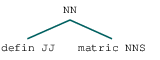

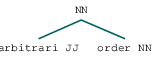

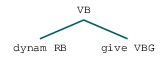

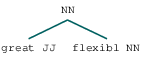

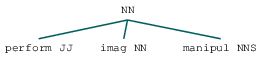

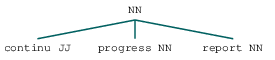

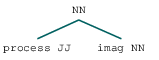

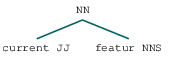

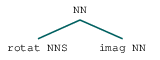

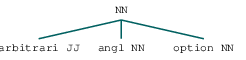

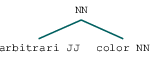

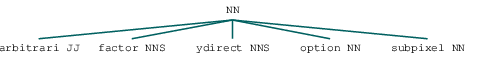

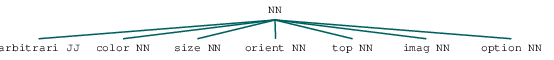

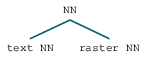

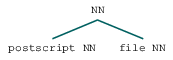

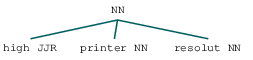

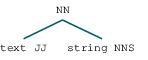

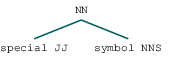

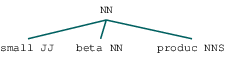

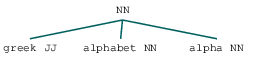

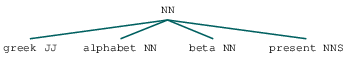

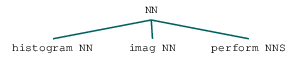

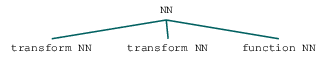

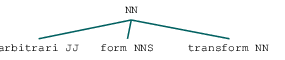

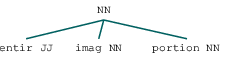

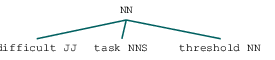

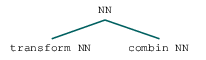

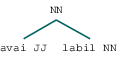

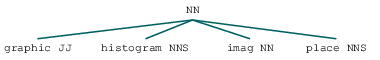

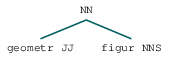

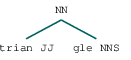

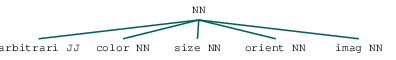

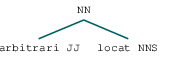

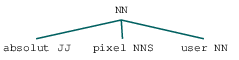

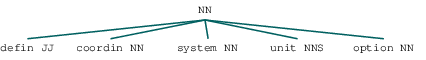

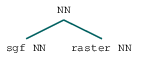

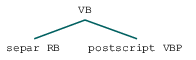

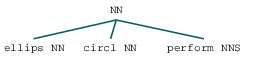

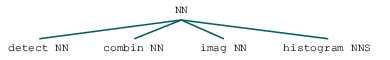

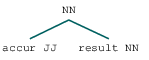

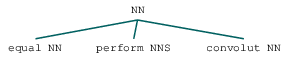

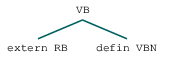

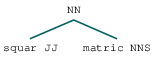

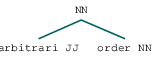

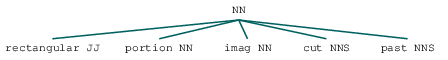

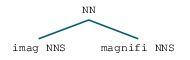

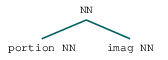

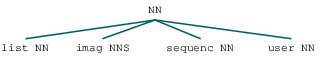

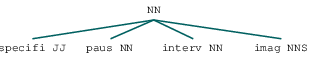

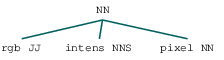

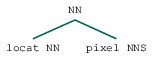

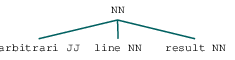

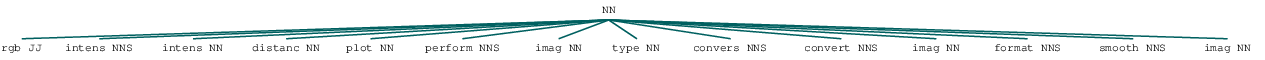

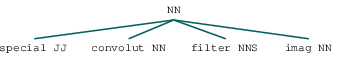

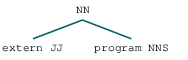

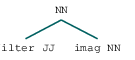

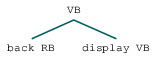

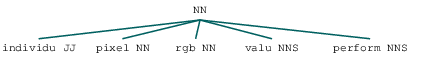

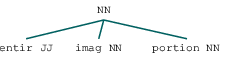

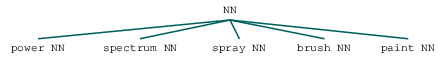

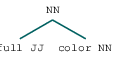

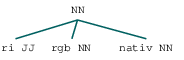

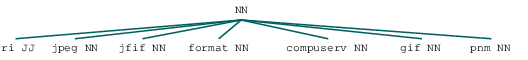

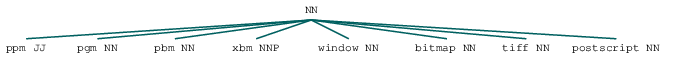

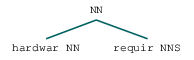

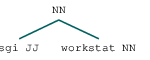

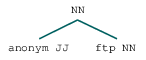

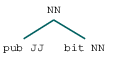

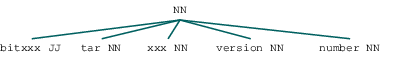

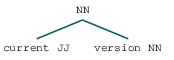

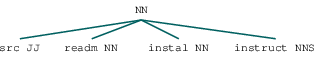

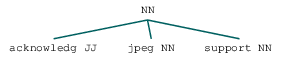

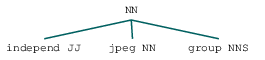

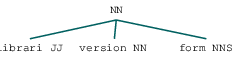

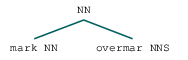

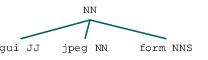

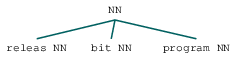

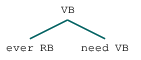

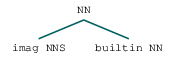

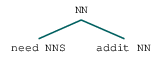

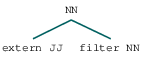

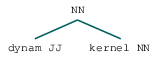

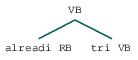

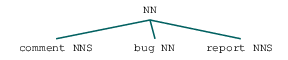

In [10]:
news_chunked = []
for i in range(len(news_no_stop_words)):
    news_chunked.append(TextProcessor.chunk(news_no_stop_words[i]))
type_tree = type(Tree('S', []))
for chunk in news_chunked[1]:
    if(type(chunk) == type_tree):
        display(chunk)

## N-Grams

In [11]:
news_2_grams = []
for i in range(len(news_no_stop_words)):
    news_2_grams.append(TextProcessor.get_ngram([x[0] for x in news_tagged[i]], 2))
for i in news_2_grams[1]:
    print(i)

('distribution', 'world')
('world', 'messageid')
('messageid', 'rs')
('rs', 'jk')
('jk', 'dna')
('dna', 'menudo')
('menudo', 'uh')
('uh', 'edu')
('edu', 'nntppostinghost')
('nntppostinghost', 'menudo')
('menudo', 'uh')
('uh', 'edu')
('edu', 'i')
('i', 'am')
('am', 'happy')
('happy', 'to')
('to', 'announce')
('announce', 'the')
('the', 'first')
('first', 'public')
('public', 'release')
('release', 'of')
('of', 'the')
('the', 'bit')
('bit', 'program')
('program', 'an')
('an', 'interactive')
('interactive', 'full')
('full', 'color')
('color', 'image')
('image', 'viewer')
('viewer', 'and')
('and', 'editor')
('editor', 'based')
('based', 'on')
('on', 'sgi')
('sgi', 'gl')
('gl', 'besides')
('besides', 'typical')
('typical', 'touchup')
('touchup', 'tasks')
('tasks', 'such')
('such', 'as')
('as', 'crop')
('crop', 'rotate')
('rotate', 'smooth')
('smooth', 'etc')
('etc', 'bit')
('bit', 'offers')
('offers', 'some')
('some', 'unique')
('unique', 'features')
('features', 'not')
('not', 'available')

# Clustering
1. Tokenize and POS tag
2. Stem and lemmatize
3. Remove stop words
4. TFIDF transform with ngrams
5. K-Means

In [12]:
def load_data_clustering():
    categories = [
        'alt.atheism',
        'comp.graphics',
        'sci.space',
        'talk.politics.guns',
        'rec.autos'
    ]
    if "20_newsgroups" not in os.listdir():
        print("Cannot find data files, exiting.")
        print("Please copy 20_newsgroups folder into the current directory before retrying execution")
    data_path = "20_newsgroups/"
    data = []
    for cat in categories:
        files = [data_path + cat + "/" + x for x in os.listdir(data_path + cat)]
        count = 0
        for i in files:
            with open(i, mode='r', encoding='utf-8', errors='ignore') as file:
                text = file.read()
                ok = False
                if len(text) > 6200:
                    ok = True
                if ok:
                    data.append([text, cat])
                    count += 1
            if count == 10:
                break
    return data

In [13]:
data_c = load_data_clustering()
labels = [x[1] for x in data_c]
news = [x[0] for x in data_c]
print(len(news))

50


## Preprocessing
1. Remove header
2. POS Tag
3. Stem and lemmatize
4. Get 3 grams

In [14]:
   {'ngram_range': (1, 3), 'use_idf': True, 'df_min_max': (0.0, 1.0), 'norm': 'l2'}
news_cleaned = []
for i in range(len(data_c)):
    news_cleaned.append(NewsGroupFile.string_noise_cancel(data_c[i][0]))

In [15]:
news_tokenized = []
for i in range(len(news_cleaned)):
    news_tokenized.append(TextProcessor.word_tokenize(news_cleaned[i]))

In [16]:
news_tagged = []
for i in range(len(news_tokenized)):
    news_tagged.append(TextProcessor.pos_tag(news_tokenized[i]))

In [17]:
news_no_stop_words = []
for i in range(len(news_tagged)):
    news_no_stop_words.append(TextProcessor.remove_stop_words_tagged(news_tagged[i])) 

In [18]:
news_stemmed_and_lemmatized = []
for i in range(len(news_no_stop_words)):
    news_stemmed_and_lemmatized.append(TextProcessor.stem_lemmatize_tagged(news_no_stop_words[i]))

In [19]:
news_processed_str = []
for i in range(len(news_stemmed_and_lemmatized)):
    tag_stripped = [x[0] for x in news_stemmed_and_lemmatized[i]]
    news_processed_str.append(' '.join(tag_stripped))

In [20]:
news_processed = news_processed_str

### Processed data sample

In [21]:
print(news_processed[0])

archivenam atheism resourc altatheismarchivenam resourc lastmodifi decemb version atheist resourc address atheist organ usa freedom religion foundat darwin fish bumper sticker assort atheist paraphernalia avail freedom religion foundat write ffrf box madison telephon evolut design evolut design sell darwin fish fish symbol like one christian stick car foot word darwin write insid delux mould plastic fish postpaid write evolut design laurel canyon north hollywood peopl san francisco bay area get darwin fish lynn gold tri mail figmo netcom com net peopl lynn directli price per fish american atheist press aap publish variou atheist book critiqu bibl list biblic contradict one book bibl handbook ball foot american atheist press isbn edit bibl contradict absurd atroc immor contain ball foot bibl contradict aap base king jame version bibl write american atheist press box austin cameron road austin telephon fax prometheu book sell book includ haught holi horror see write east amherst street b

## Transformation and Clustering

### Trying out several hyperparameters

In [22]:
# Code to generate and test a long list of hyperparameters, commented out after finding the best hyperparameter set.

# hyperparam_ranges = {
#     "ngram_range": [],
#     "use_idf": [True, False],
#     "df_min_max": [],
#     "norm": ['l1','l2'],
# }
# for range1 in range(1, 3):
#     for range2 in range(range1, 6):
#         hyperparam_ranges["ngram_range"].append((range1, range2))
# for range1 in range(0, 3):
#     for range2 in range(range1 + 1, 11):
#         hyperparam_ranges["df_min_max"].append((range1/10, range2/10))
        
# hyperparams_set = []
# thirteen = None
# for ngram_range in hyperparam_ranges["ngram_range"]:
#     for use_idf in hyperparam_ranges["use_idf"]:
#         for df_min_max in hyperparam_ranges["df_min_max"]:
#             for norm in hyperparam_ranges["norm"]:
#                 hyperparams_set.append(
#                     {
#                         "ngram_range": ngram_range,
#                         "use_idf": use_idf,
#                         "df_min_max": df_min_max,
#                         "norm": norm
#                     }
#                 )
# print(len(hyperparams_set), "sets of hyperparameters generated")

In [23]:
# y = labels
# homogeneity_scores = []
# v_scores = []
# test_progress = 0
# for hyperparams in hyperparams_set:
#     vectorizer = TfidfVectorizer(ngram_range=hyperparams["ngram_range"],
#                                      stop_words='english',
#                                      use_idf=hyperparams["use_idf"],
#                                      strip_accents='ascii',
#                                      lowercase=True,
#                                      max_df=hyperparams["df_min_max"][1],
#                                      min_df=hyperparams["df_min_max"][0],
#                                      norm=hyperparams["norm"],
#                                 )
#     try:
#         X = vectorizer.fit_transform(news_processed)
#         X = np.array(X.toarray())
#         km = KMeans(n_clusters=5, max_iter=100, random_state=0)
#         km.fit(X)
#         y_pred = km.predict(X)
#         homogeneity_scores.append(homogeneity_score(y, y_pred))
#         v_scores.append(v_measure_score(y, y_pred))
#     except:
#         homogeneity_scores.append(0)
#         v_scores.append(0)
#     test_progress += 1
#     if test_progress % 100 == 0:
#         print(test_progress, "sets tested")
# print(test_progress, "sets tested. Terminating.")

In [24]:
# print(len(v_scores))
# print("Set\t Homo\t V")
# for i in range(len(homogeneity_scores)):
#     if homogeneity_scores[i] > 0.5 or v_scores[i] > 0.5:
#         print(i, "\t", "%.2f \t %.2f" % (homogeneity_scores[i], v_scores[i]))

In [25]:
# print(hyperparams_set[1])

### Best hyperparameter set found so far
After stemming and lemmatization
   ```
   {'ngram_range': (1, 7), 'use_idf': True, 'df_min_max': (0.1, 0.9), 'norm': 'l2'}
   ```

In [26]:
y = labels
hyperparams = {'ngram_range': (1, 7), 'use_idf': True, 'df_min_max': (0.1, 0.9), 'norm': 'l2'} # Best hyperparams found so far
vectorizer = TfidfVectorizer(ngram_range=hyperparams["ngram_range"],
                                 stop_words='english',
                                 use_idf=hyperparams["use_idf"],
                                 strip_accents='ascii',
                                 lowercase=True,
                                 max_df=hyperparams["df_min_max"][1],
                                 min_df=hyperparams["df_min_max"][0],
                                 norm=hyperparams["norm"],
                            )
X = vectorizer.fit_transform(news_processed)
X = np.array(X.toarray())
km = KMeans(n_clusters=5, max_iter=100, random_state=0)

km.fit(X)
y_pred = km.predict(X)
print("Homogeneity Score\t: %.3f" % homogeneity_score(y, y_pred))
print("V Score\t\t\t: %.3f" % v_measure_score(y, y_pred))

Homogeneity Score	: 0.760
V Score			: 0.761


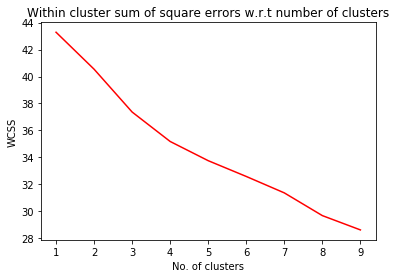

In [27]:
lim = 10
homo_scores = []
v_scores = []
wcss_errs = []
for n_clusters in range(1, lim): 
    km = KMeans(n_clusters=n_clusters, max_iter=100, random_state=0)
    km.fit(X)
    y_pred = km.predict(X)
    wcss_errs.append(km.inertia_)
    homo_scores.append(homogeneity_score(y, y_pred))
    v_scores.append(v_measure_score(y, y_pred))
plt.plot(range(1, lim), [x for x in wcss_errs], c='red')
plt.title("Within cluster sum of square errors w.r.t number of clusters")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")
plt.savefig("wcss-wrt-n-of-clusters.png")
# plt.show()